# Практикум №3
# Тітікова Артема, студента групи КА-01
# 11 варіант
## Реалізація багатошарового персептрона для класифікації зображень MNIST в TensorFlow з нуля
## Данні - The Street View House Numbers (SVHN), kaggle.com

Я знайшов цей датасет у вигляді numpy array, тому буду використовувати його, також я не буду використовувати увесь датасет, тому що повний займає більше 2 гб данних і я не зміг його занести у google colab, а моєму компьютеру не вистачає обчислювальних здібностей, щоб хоч якось цю кількість інформації обрахувати

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

n_epochs = 300
lrn = 1e-2


full_ds = np.load('/content/drive/MyDrive/svnh/X_test.npy')
full_labels_ds = np.squeeze(np.load('/content/drive/MyDrive/svnh/y_test.npy'))
full_ds.shape

(32, 32, 3, 26032)

Переведемо нашу матрицю до іншого вигляду

In [4]:
transposed_df = np.transpose(full_ds, (3, 0, 1, 2))
transposed_df.shape

(26032, 32, 32, 3)

Виведемо значення для одного пікселя, та подивимось чи нормалізовані вже дані

In [5]:
transposed_df[0][0][0]

array([0.1484375 , 0.40234375, 0.234375  ])

Як ми бачимо дані вже нормалізовані, давайте подивимося на кольорові випадкові приклади з лейблами перед тим як ми будемо видаляти 2 кольори з них (переведемо до greyscale)

In [6]:
def plot_rand_colored_images(images, labels):     
    fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)  
    ax = axs.flatten()
    for i, ax in enumerate(axs.flatten()):
        img = images[labels == i][0]
        ax.imshow(img)
        ax.set_title(i)
        ax.axis('off')

    fig.suptitle('examples of indices')
    fig.tight_layout()
    plt.show()

In [7]:
def plot_greyscale_images(images, labels):
    fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)  
    ax = axs.flatten()
    for i, ax in enumerate(axs.flatten()):
        img = images[labels == i][0].reshape(32, 32)
        ax.imshow(img, cmap='Greys')
        ax.set_title(i)
        ax.axis('off')

    fig.suptitle('examples of indices turned to greyscale')
    fig.tight_layout()
    plt.show()

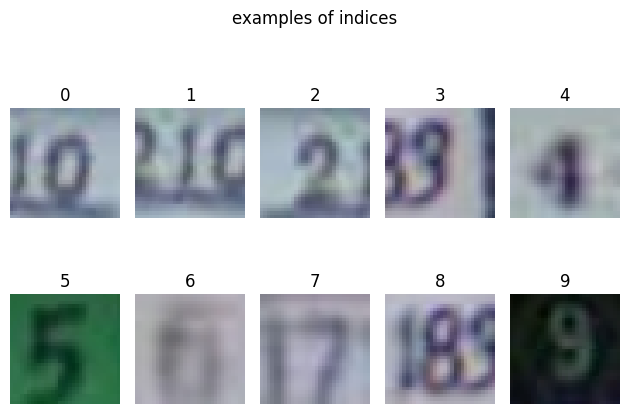

In [8]:
plot_rand_colored_images(transposed_df, full_labels_ds)

Як ми бачимо наші дані дуже замилені, та не усі мають чіткі контури

In [9]:
def flatten_and_remove_dim(arr):
    grayscaled_arr = np.dot(arr, [0.2989, 0.5870, 0.1140])
    return np.reshape(grayscaled_arr, (grayscaled_arr.shape[0], -1))

In [10]:
flattened_ds = flatten_and_remove_dim(transposed_df)

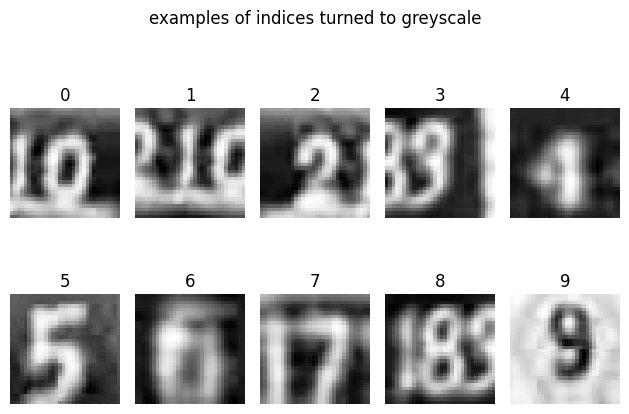

In [11]:
plot_greyscale_images(flattened_ds, full_labels_ds)

Тут ми можемо побачити, що деякі наші дані майже неможливо розібрати, та ма.ть інвертовані кольори порівняно з іншими

# Розділимо дані на тренувальний, валідаційний та тестовий

Оскільки softmax повертає вірогідності для усіх лейблів, то нам потрібно заенкодити нашу цільову змінну через One Hot Encoding

In [12]:
OHE = OneHotEncoder()

full_labels_ds_encoded = OHE.fit_transform(full_labels_ds.reshape(-1, 1)).toarray()

Перевіримо:

In [13]:
full_labels_ds_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(flattened_ds, full_labels_ds_encoded, test_size=0.2, stratify=full_labels_ds_encoded)

In [15]:
X_train, X_test, y_train, y_test = tf.constant(X_train, dtype=tf.float32), tf.constant(X_test, dtype=tf.float32), \
                                    tf.constant(y_train, dtype=tf.float32), tf.constant(y_test, dtype=tf.float32)

# Базова мережу прямого розповсюдження сигналу з єдиним вихiдним шаром softmax.

In [16]:
class Feedforward(tf.Module):
    def __init__(self, in_features, out_features):
        self.w = tf.Variable(tf.random.normal([in_features, out_features]))
        self.b = tf.Variable(tf.zeros([1]))

    def forward_pass(self, X):
        return (tf.matmul(X, self.w) + self.b)

    def compute_loss(self, logits, labels):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        return tf.reduce_mean(loss)

    def train_step(self, X, y, lrn):

        with tf.GradientTape() as tape:
            logits = self.forward_pass(X)
            loss = self.compute_loss(logits=logits, labels=y)

        dw, db = tape.gradient(loss, [self.w, self.b])

        self.w.assign_sub(lrn * dw)
        self.b.assign_sub(lrn * db)

        return loss.numpy() 

    def save_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.save(checkpoint_path)

    def load_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.restore(checkpoint_path)

    def fit(self, X_train, y_train, X_test, y_test, epochs, lrn=1e-2):
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_val_loss = float("inf")

        for epoch in range(epochs): # tqdm()
            epoch_train_loss = 0

            loss = self.train_step(X_train, y_train, lrn=lrn)
            
            history['train_loss'].append(loss)
            history['val_loss'].append(self.compute_loss(self.forward_pass(X_test), y_test).numpy())  

            history['train_acc'].append(accuracy_score(tf.argmax(y_train, axis=1), self.predict(X_train)))
            history['val_acc'].append(accuracy_score(tf.argmax(y_test, axis=1), self.predict(X_test)))

            if epoch % 100 == 0:
                print(f'Epoch {epoch}')
                print(f"Train loss: {history['train_loss'][-1]}")
                print(f"Val loss: {history['val_loss'][-1]}")
                print(f"Train acc: {history['train_acc'][-1]}")
                print(f"Val acc: {history['val_acc'][-1]}")

            if history['val_loss'][-1] < best_val_loss:
                self.save_model('/content/checkpoints')
                best_val_loss = history['val_loss'][-1]

        return history

    def predict(self, X):
        return tf.argmax(self.forward_pass(X), axis=1)

In [17]:
%%time

feedforward_model = Feedforward(X_train.shape[1], y_train.shape[1])

history = feedforward_model.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 21.785564422607422
Val loss: 19.82358169555664
Train acc: 0.08139255702280912
Val acc: 0.0812367966199347
Epoch 100
Train loss: 6.569314002990723
Val loss: 6.553769111633301
Train acc: 0.12873949579831934
Val acc: 0.127520645285193
Epoch 200
Train loss: 6.147308349609375
Val loss: 6.144311428070068
Train acc: 0.125906362545018
Val acc: 0.12329556366429806
CPU times: user 5.99 s, sys: 558 ms, total: 6.55 s
Wall time: 8.29 s


Text(0.5, 1.0, 'Loss')

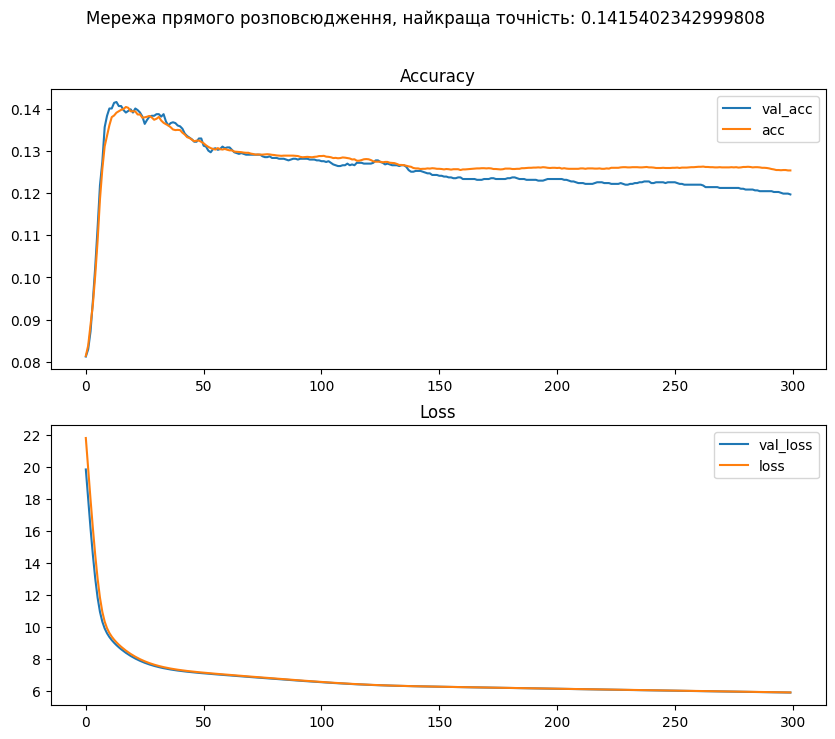

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа прямого розповсюдження, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Ми отримали модель яка дуже погано себе показує на даних, на мою думку це пов'язано з тим у якому вигляді наші дані, вони зашумлені, не всі цифри однакового кольору, що дуже важливо для таких моделей

Як ми бачимо наша модель дала найкращий результат точності у ~17.7, але це було на початку, згодом наша точність лише падала, хоча і функція втрат ставала кращою, але для неї також адекватний результат ми не отримали

Більша кількість епох на результат не впливають, тут насправді нічого на результат не впливає окрім того які ваги ми отримали напочатку через нормальний розподіл і тут ми у ситуації коли, або ми завжди попадаємо у локальний мінімум, або ми навіть коли ми досягаємо глобального мінімуму він також жахливий і ми не отримуємо гарних значень у метриках, але я усе ж таки більше схиляюся до того, що наш тип моделі не підходить для цих даних, тому більша кількість шарів наврядчи тут допоможе, мабуть тут зможуть допомогти інші типи шарів

# Мережа прямого розповсюдження сигналу з кiлькома скритими шарами

## Один скритий шар

In [19]:
class OneLayer(tf.Module):
    def __init__(self, in_features, out_features, activation_fn='relu'):
        self.w0 = tf.Variable(tf.random.normal([in_features, 100]))
        self.b0 = tf.Variable(tf.zeros([1]))

        self.w1 = tf.Variable(tf.random.normal([100, 50]))
        self.b1 = tf.Variable(tf.zeros([1]))

        self.w2 = tf.Variable(tf.random.normal([50, 10]))
        self.b2 = tf.Variable(tf.zeros([1]))

        self.activation_fn = activation_fn

    def forward_pass(self, X):
        if self.activation_fn == 'relu':
            x1 = tf.nn.relu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.relu(tf.matmul(x1, self.w1) + self.b1)
            return (tf.matmul(x2, self.w2) + self.b2) 

        elif self.activation_fn == 'leaky_relu':
            x1 = tf.nn.leaky_relu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.leaky_relu(tf.matmul(x1, self.w1) + self.b1)
            return (tf.matmul(x2, self.w2) + self.b2)

        elif self.activation_fn == 'elu':
            x1 = tf.nn.elu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.elu(tf.matmul(x1, self.w1) + self.b1)
            return (tf.matmul(x2, self.w2) + self.b2)

        else: 
            raise ValueError("possible values are: 'relu', 'leaky_relu', 'elu'")
        

    def compute_loss(self, logits, labels):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        return tf.reduce_mean(loss)

    def train_step(self, X, y, lrn):

        with tf.GradientTape() as tape:
            logits = self.forward_pass(X)
            loss = self.compute_loss(logits=logits, labels=y)

        dw2, dw1, dw0, db2, db1, db0 = tape.gradient(loss, [self.w2, self.w1, self.w0, self.b2, self.b1, self.b0]) 

        self.w2.assign_sub(lrn * dw2)
        self.b2.assign_sub(lrn * db2)

        self.w1.assign_sub(lrn * dw1)
        self.b1.assign_sub(lrn * db1)

        self.w0.assign_sub(lrn * dw0)
        self.b0.assign_sub(lrn * db0)

        return loss.numpy() 

    def save_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.save(checkpoint_path)

    def load_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.restore(checkpoint_path)

    def fit(self, X_train, y_train, X_test, y_test, epochs, lrn=1e-2):
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_val_loss = float("inf")

        for epoch in range(epochs):
            epoch_train_loss = 0

            loss = self.train_step(X_train, y_train, lrn=lrn)
            
            history['train_loss'].append(loss)
            history['val_loss'].append(self.compute_loss(self.forward_pass(X_test), y_test).numpy())  

            history['train_acc'].append(accuracy_score(tf.argmax(y_train, axis=1), self.predict(X_train)))
            history['val_acc'].append(accuracy_score(tf.argmax(y_test, axis=1), self.predict(X_test)))

            if epoch % 100 == 0:
                print(f'Epoch {epoch}')
                print(f"Train loss: {history['train_loss'][-1]}")
                print(f"Val loss: {history['val_loss'][-1]}")
                print(f"Train acc: {history['train_acc'][-1]}")
                print(f"Val acc: {history['val_acc'][-1]}")

            if history['val_loss'][-1] < best_val_loss:
                self.save_model('/content/checkpoints')
                best_val_loss = history['val_loss'][-1]

        return history

    def predict(self, X):
        return tf.argmax(tf.nn.softmax(self.forward_pass(X)), axis=1)

In [20]:
%%time

onelayer_model_relu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='relu')

history = onelayer_model_relu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 399.63629150390625
Val loss: 1529.1668701171875
Train acc: 0.15971188475390155
Val acc: 0.15997695410024967
Epoch 100
Train loss: 3.1057353019714355
Val loss: 3.003814220428467
Train acc: 0.07375750300120049
Val acc: 0.07297868254273093
Epoch 200
Train loss: 2.6577537059783936
Val loss: 2.583239793777466
Train acc: 0.07092436974789916
Val acc: 0.07086614173228346
CPU times: user 8.6 s, sys: 590 ms, total: 9.19 s
Wall time: 8.77 s


Text(0.5, 1.0, 'Loss')

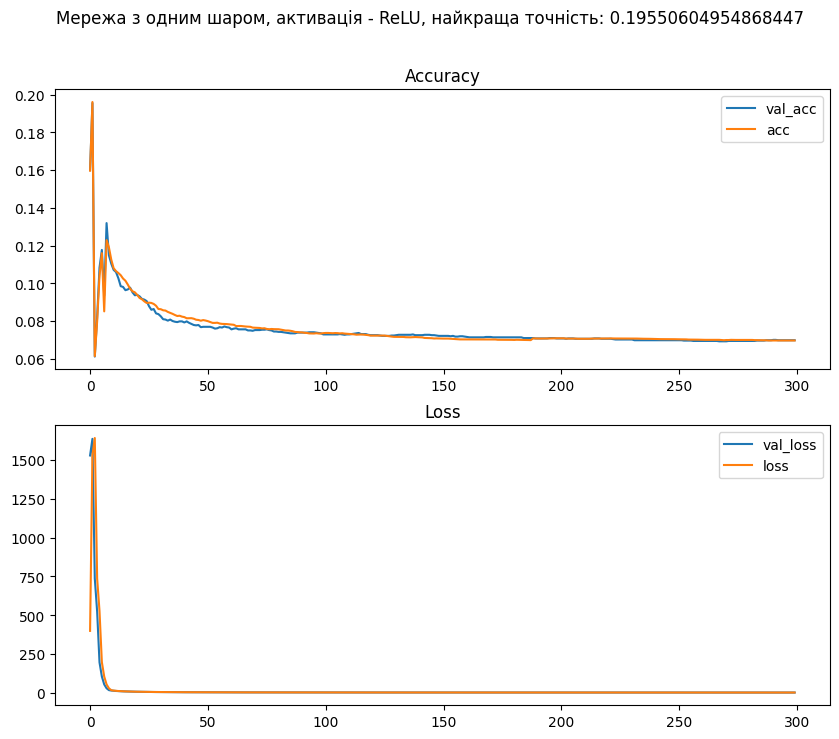

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ReLU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних

In [22]:
%%time

onelayer_model_leaky_relu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='leaky_relu')

history = onelayer_model_leaky_relu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 613.3792114257812
Val loss: 635.80908203125
Train acc: 0.114093637454982
Val acc: 0.11292490877664682
Epoch 100
Train loss: 19.811552047729492
Val loss: 20.07679557800293
Train acc: 0.10919567827130852
Val acc: 0.10601113885154599
Epoch 200
Train loss: 13.496603012084961
Val loss: 13.085549354553223
Train acc: 0.1549579831932773
Val acc: 0.1595928557710774
CPU times: user 6.58 s, sys: 220 ms, total: 6.8 s
Wall time: 6.58 s


Text(0.5, 1.0, 'Loss')

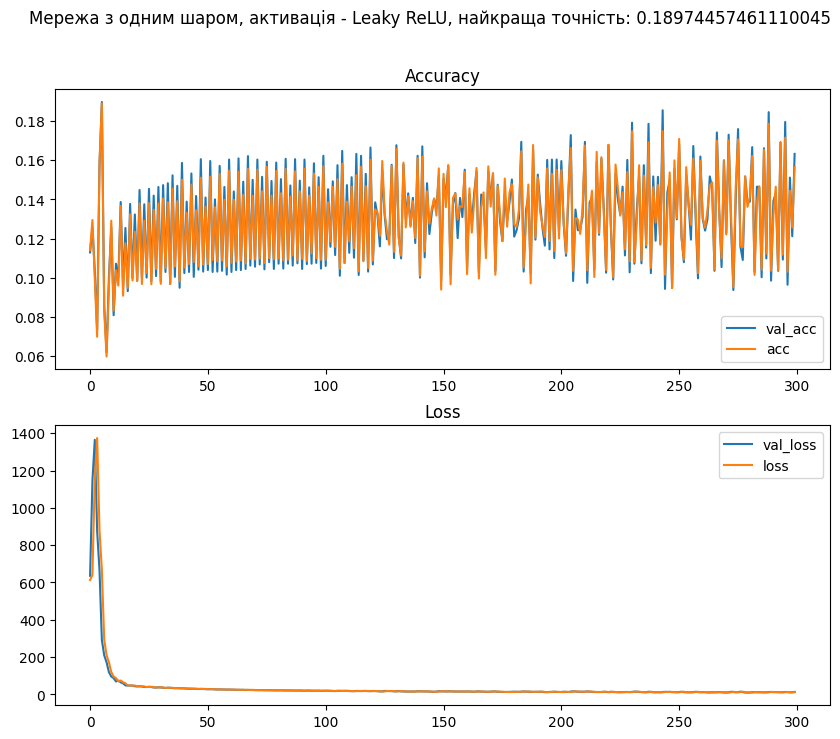

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - Leaky ReLU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних, хоч ми і отримали дуже цікавий малюнок точності

In [24]:
%%time

onelayer_model_elu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = onelayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 515.8468017578125
Val loss: 1177.3050537109375
Train acc: 0.1499639855942377
Val acc: 0.1517188400230459
Epoch 100
Train loss: 3.5419211387634277
Val loss: 3.672696113586426
Train acc: 0.19183673469387755
Val acc: 0.19032072210485884
Epoch 200
Train loss: 2.6528701782226562
Val loss: 2.7545955181121826
Train acc: 0.19346938775510203
Val acc: 0.19147301709237566
CPU times: user 8.5 s, sys: 594 ms, total: 9.09 s
Wall time: 8.69 s


Text(0.5, 1.0, 'Loss')

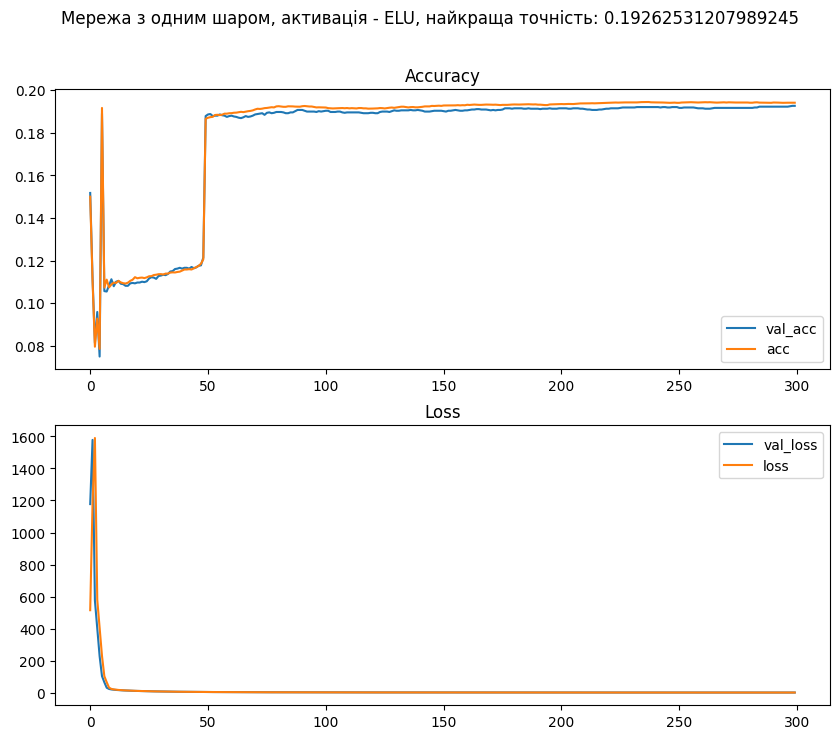

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних

## Два шари

In [26]:
class TwoLayer(tf.Module):
    def __init__(self, in_features, out_features, activation_fn='relu'):
        self.w0 = tf.Variable(tf.random.normal([in_features, 200]))
        self.b0 = tf.Variable(tf.zeros([1]))

        self.w1 = tf.Variable(tf.random.normal([200, 150]))
        self.b1 = tf.Variable(tf.zeros([1]))

        self.w2 = tf.Variable(tf.random.normal([150, 50]))
        self.b2 = tf.Variable(tf.zeros([1]))

        self.w3 = tf.Variable(tf.random.normal([50, 10]))
        self.b3 = tf.Variable(tf.zeros([1]))

        self.activation_fn = activation_fn

    def forward_pass(self, X):
        if self.activation_fn == 'relu':
            x1 = tf.nn.relu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.relu(tf.matmul(x1, self.w1) + self.b1)
            x3 = tf.nn.relu(tf.matmul(x2, self.w2) + self.b2)
            return (tf.matmul(x3, self.w3) + self.b3) 

        elif self.activation_fn == 'leaky_relu':
            x1 = tf.nn.leaky_relu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.leaky_relu(tf.matmul(x1, self.w1) + self.b1)
            x3 = tf.nn.leaky_relu(tf.matmul(x2, self.w2) + self.b2)
            return (tf.matmul(x3, self.w3) + self.b3)

        elif self.activation_fn == 'elu':
            x1 = tf.nn.elu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.elu(tf.matmul(x1, self.w1) + self.b1)
            x3 = tf.nn.elu(tf.matmul(x2, self.w2) + self.b2)
            return (tf.matmul(x3, self.w3) + self.b3)

        else: 
            raise ValueError("possible values are: 'relu', 'leaky_relu', 'elu'")
        

    def compute_loss(self, logits, labels):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        return tf.reduce_mean(loss)

    def train_step(self, X, y, lrn):

        with tf.GradientTape() as tape:
            logits = self.forward_pass(X)
            loss = self.compute_loss(logits=logits, labels=y)

        dw3, dw2, dw1, dw0, db3, db2, db1, db0 = tape.gradient(loss, [self.w3, self.w2, self.w1, self.w0, self.b3, self.b2, self.b1, self.b0]) 

        self.w3.assign_sub(lrn * dw3)
        self.b3.assign_sub(lrn * db3)

        self.w2.assign_sub(lrn * dw2)
        self.b2.assign_sub(lrn * db2)

        self.w1.assign_sub(lrn * dw1)
        self.b1.assign_sub(lrn * db1)

        self.w0.assign_sub(lrn * dw0)
        self.b0.assign_sub(lrn * db0)

        return loss.numpy() 

    def save_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.save(checkpoint_path)

    def load_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.restore(checkpoint_path)

    def fit(self, X_train, y_train, X_test, y_test, epochs, lrn=1e-2):
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_val_loss = float("inf")

        for epoch in range(epochs): 
            epoch_train_loss = 0

            loss = self.train_step(X_train, y_train, lrn=lrn)
            
            history['train_loss'].append(loss)
            history['val_loss'].append(self.compute_loss(self.forward_pass(X_test), y_test).numpy())  

            history['train_acc'].append(accuracy_score(tf.argmax(y_train, axis=1), self.predict(X_train)))
            history['val_acc'].append(accuracy_score(tf.argmax(y_test, axis=1), self.predict(X_test)))

            if epoch % 100 == 0:
                print(f'Epoch {epoch}')
                print(f"Train loss: {history['train_loss'][-1]}")
                print(f"Val loss: {history['val_loss'][-1]}")
                print(f"Train acc: {history['train_acc'][-1]}")
                print(f"Val acc: {history['val_acc'][-1]}")

            if history['val_loss'][-1] < best_val_loss:
                self.save_model('/content/checkpoints')
                best_val_loss = history['val_loss'][-1]

        return history


    def predict(self, X):
        return tf.argmax(tf.nn.softmax(self.forward_pass(X)), axis=1)

In [27]:
%%time

twolayer_model_relu = TwoLayer(X_train.shape[1], y_train.shape[1], activation_fn='relu')

history = twolayer_model_relu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 15342.251953125
Val loss: 334520.4375
Train acc: 0.15937575030012005
Val acc: 0.15940080660649125
Epoch 100
Train loss: 2.3025853633880615
Val loss: 2.3025853633880615
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
Epoch 200
Train loss: 2.3025853633880615
Val loss: 2.3025853633880615
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
CPU times: user 6.4 s, sys: 116 ms, total: 6.52 s
Wall time: 6.37 s


Text(0.5, 1.0, 'Loss')

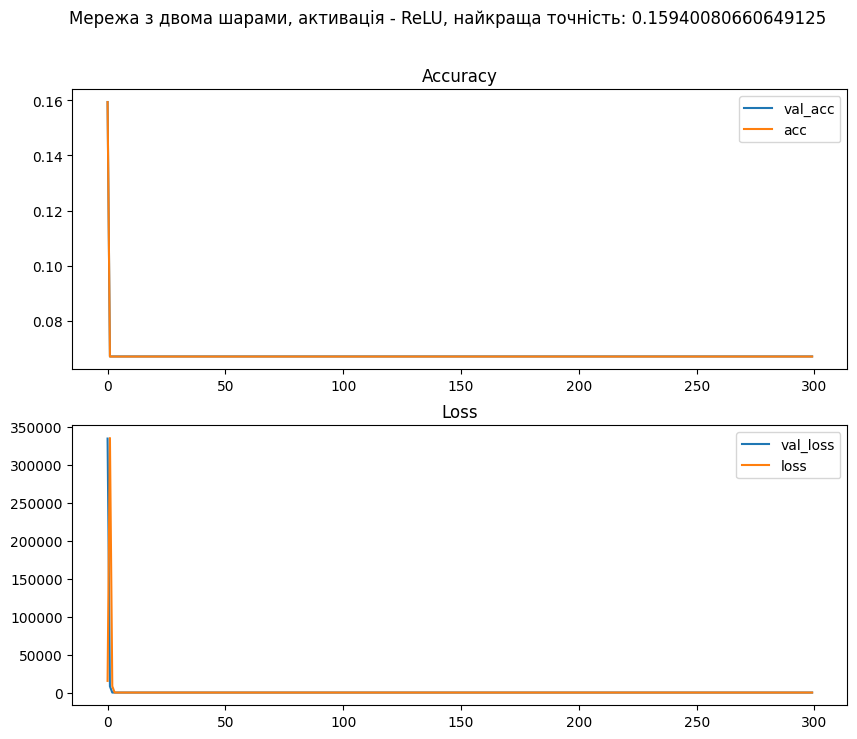

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з двома шарами, активація - ReLU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних, майже одразу потрапила до мінімуму, не можливо визначати глобального чи локального, і не покращувалася

In [29]:
%%time

twolayer_model_leaky_relu = TwoLayer(X_train.shape[1], y_train.shape[1], activation_fn='leaky_relu')

history = twolayer_model_leaky_relu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 14096.7861328125
Val loss: 278738.65625
Train acc: 0.06127250900360144
Val acc: 0.061263683502976764
Epoch 100
Train loss: nan
Val loss: nan
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
Epoch 200
Train loss: nan
Val loss: nan
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
CPU times: user 6.49 s, sys: 123 ms, total: 6.61 s
Wall time: 6.47 s


Text(0.5, 1.0, 'Loss')

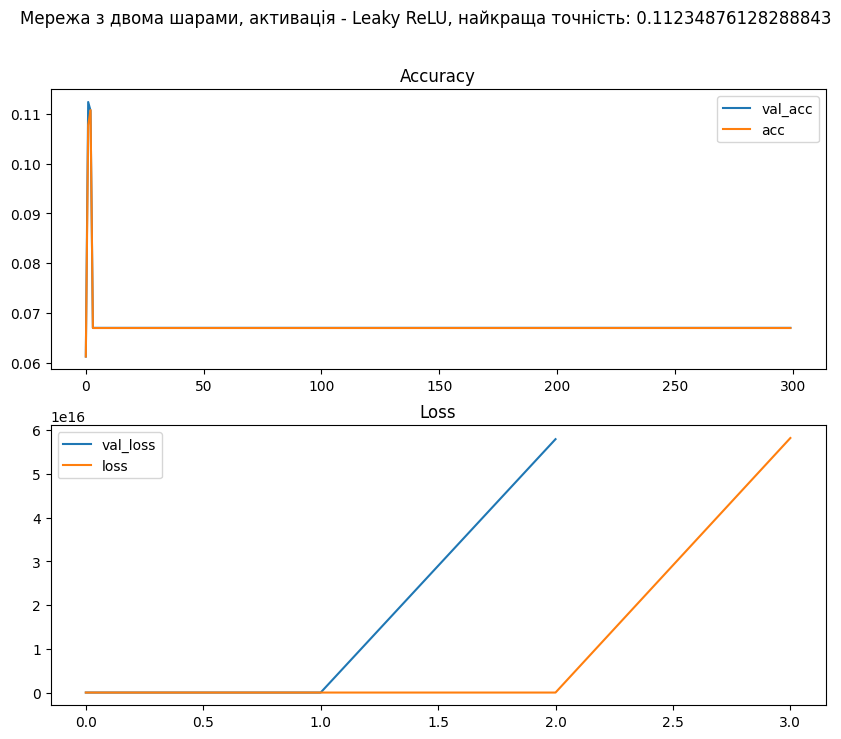

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з двома шарами, активація - Leaky ReLU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних, ця і зовсім перестала отримувати значення функції втрат, я не можу пояснити чому, код майже не змінювався порівняно з іншими моделями

In [34]:
%%time

twolayer_model_elu = TwoLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = twolayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = lrn)

Epoch 0
Train loss: 7101.69970703125
Val loss: 478073.96875
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
Epoch 100
Train loss: 25758.1796875
Val loss: 25757.037109375
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
Epoch 200
Train loss: 25721.939453125
Val loss: 25720.794921875
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
CPU times: user 10.3 s, sys: 836 ms, total: 11.2 s
Wall time: 10.6 s


Text(0.5, 1.0, 'Loss')

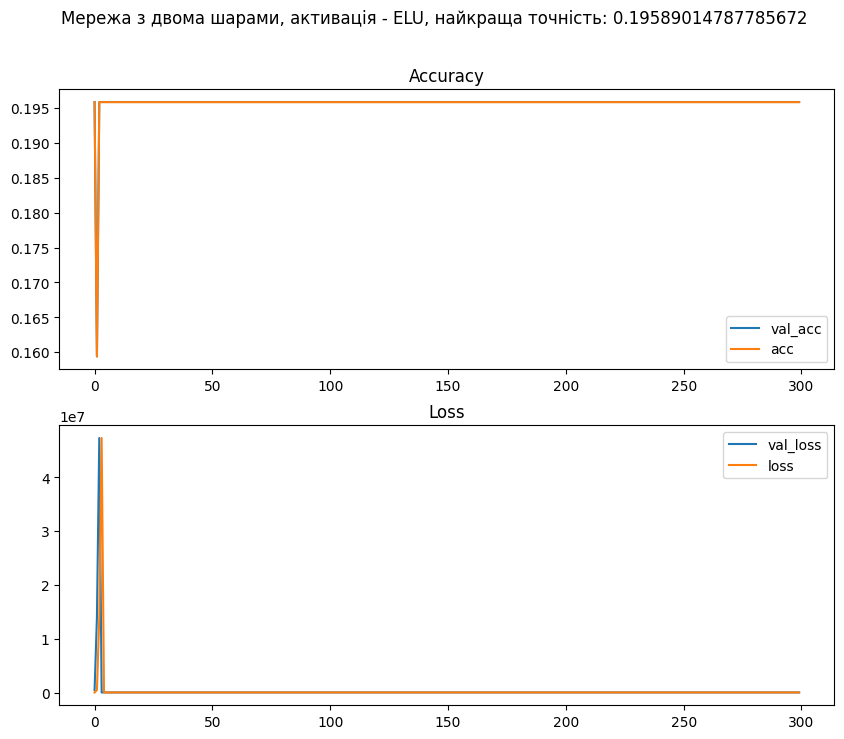

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з двома шарами, активація - ELU, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Модель навчилася досить швидко, але як ми бачимо також себе показала погано на даних, тут ми також бачимо "циклічну" точність і функцію втрат зі значенням ~100000 (що дуже багато)

# Спробуємо налаштувати швидкість навчання

Але насправді вже завідомо відомо, що це ні на що не вплине, будемо використовувати одношарову модель з ELU, тому що вона виглядає так ніби вона хоч трохи навчається

## 0.05

In [38]:
%%time

onelayer_model_elu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = onelayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = 0.05)

Epoch 0
Train loss: 816.234619140625
Val loss: 11863.32421875
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
Epoch 100
Train loss: 534.5418701171875
Val loss: 781.9735107421875
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
Epoch 200
Train loss: 464.0364990234375
Val loss: 684.4838256835938
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
CPU times: user 5.67 s, sys: 137 ms, total: 5.81 s
Wall time: 5.65 s


Text(0.5, 1.0, 'Loss')

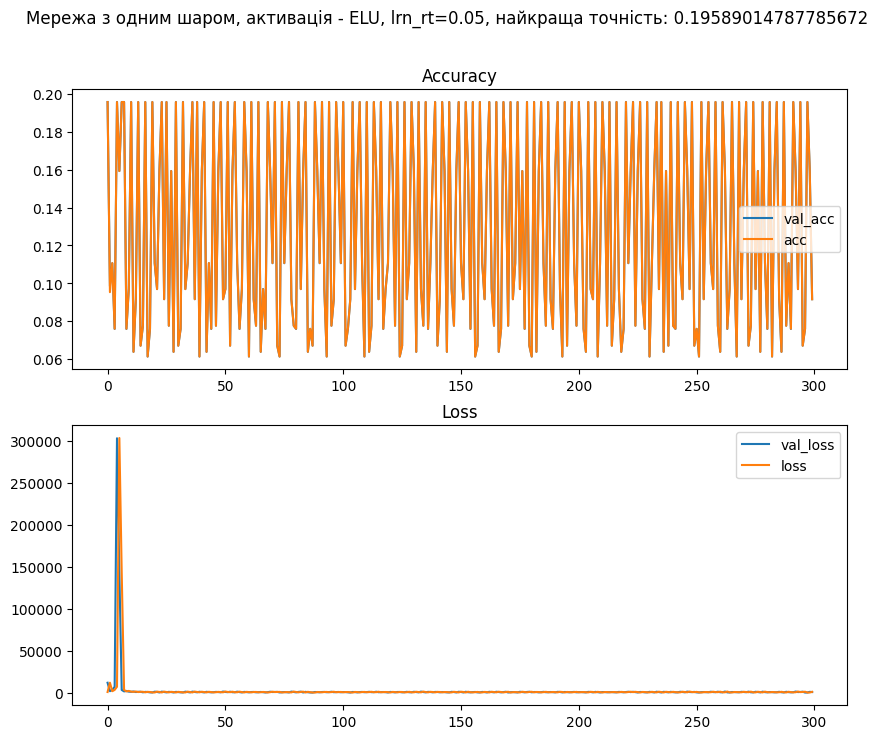

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, lrn_rt=0.05, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

## 0.1

In [40]:
%%time

onelayer_model_elu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = onelayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = 0.05)

Epoch 0
Train loss: 1120.6976318359375
Val loss: 6855.705078125
Train acc: 0.1958703481392557
Val acc: 0.19589014787785672
Epoch 100
Train loss: 125.61829376220703
Val loss: 124.734130859375
Train acc: 0.19582232893157264
Val acc: 0.1956980987132706
Epoch 200
Train loss: 61.4210319519043
Val loss: 60.88755416870117
Train acc: 0.1957262905162065
Val acc: 0.19589014787785672
CPU times: user 8.27 s, sys: 554 ms, total: 8.83 s
Wall time: 8.43 s


Text(0.5, 1.0, 'Loss')

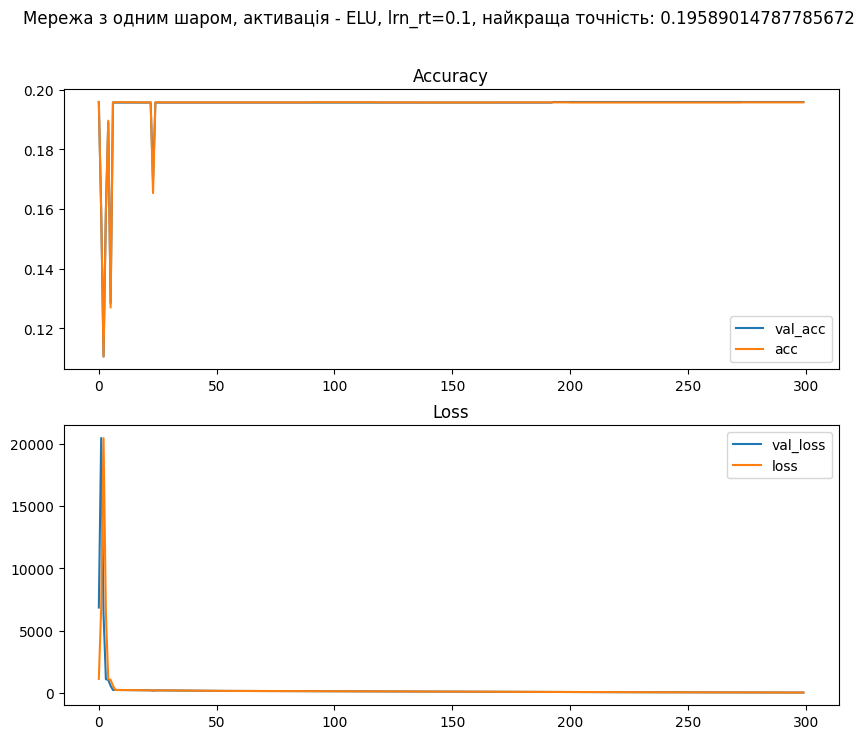

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, lrn_rt=0.1, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

## 0.15

In [42]:
%%time

onelayer_model_elu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = onelayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = 0.05)

Epoch 0
Train loss: 791.3449096679688
Val loss: 3364.363037109375
Train acc: 0.19563025210084034
Val acc: 0.19589014787785672
Epoch 100
Train loss: 34.90694808959961
Val loss: 16.46504783630371
Train acc: 0.09171668667466987
Val acc: 0.0914154023429998
Epoch 200
Train loss: 17.966598510742188
Val loss: 7.95979642868042
Train acc: 0.0672749099639856
Val acc: 0.06702515844056078
CPU times: user 5.84 s, sys: 128 ms, total: 5.97 s
Wall time: 5.81 s


Text(0.5, 1.0, 'Loss')

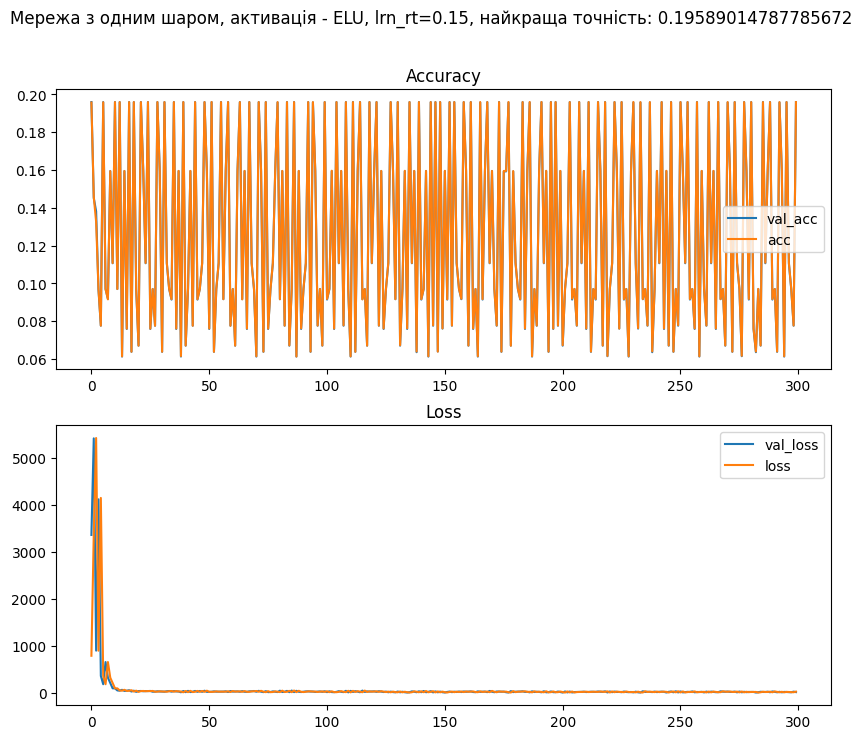

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, lrn_rt=0.15, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

## 0.2

In [44]:
%%time

onelayer_model_elu = OneLayer(X_train.shape[1], y_train.shape[1], activation_fn='elu')

history = onelayer_model_elu.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = 0.05)

Epoch 0
Train loss: 747.51171875
Val loss: 3653.907470703125
Train acc: 0.19591836734693877
Val acc: 0.19589014787785672
Epoch 100
Train loss: 59.5900764465332
Val loss: 23.237979888916016
Train acc: 0.11073229291716687
Val acc: 0.11062031880161322
Epoch 200
Train loss: 44.390811920166016
Val loss: 40.74713897705078
Train acc: 0.11073229291716687
Val acc: 0.11062031880161322
CPU times: user 5.66 s, sys: 157 ms, total: 5.82 s
Wall time: 5.65 s


Text(0.5, 1.0, 'Loss')

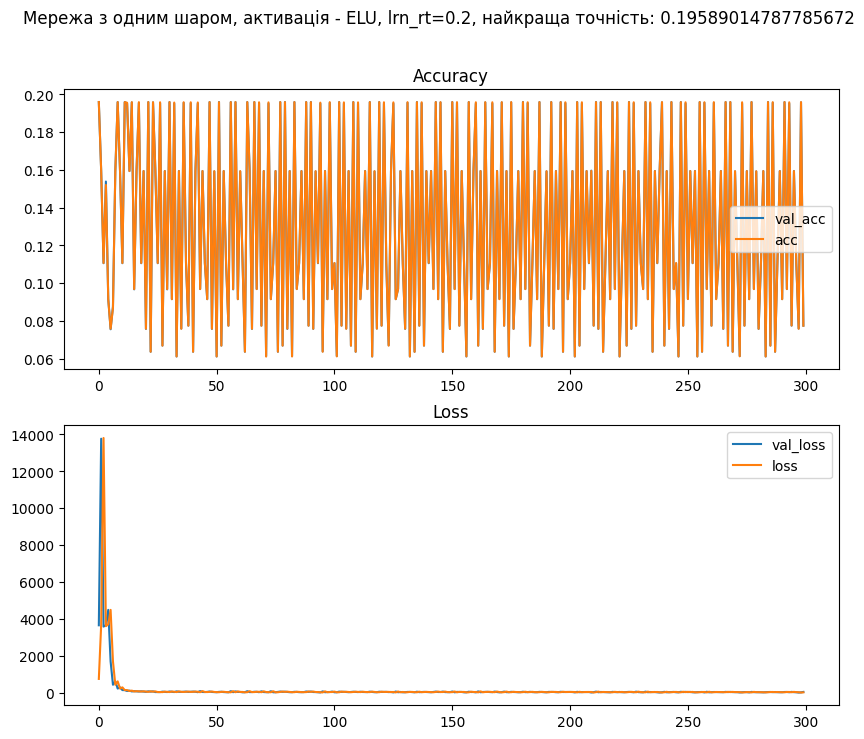

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, lrn_rt=0.2, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

Ну з цього тесту насправді видно, що найкраще, що модель може нам дати це ~20% точності, тому тест не був марним, але питання з приводу того, чого точність так різко і циклічно скаче залишається відкритим, я не можу дати відповідь на це

Мабуть це і є глобальний мінімум функції втрат

# Висновок:
У даній лабораторній роботі я навчився реалізації багатошарового персептрона для класифікації зображень MNIST в TensorFlow з нуля, створенню власного класу, використовуючи, наприклад, tf.Module або object.

На жаль дані не підходять під такий тип нейронної мережі і ми не отримали задовільних результатів, більше до цього додати нічого

Моделі навчалися швидко і, на мою думку, ми змогли досягти глобального мінімуму для нашої функції втрат

Також я спробував більш глибоку мережу (лише з активацією relu), але вона також не дала задовільних результатів і повертала nan як функції втрат одразу


# Нейрона мережа на велику кількість шарів (6)

In [50]:
class ManyLayers(tf.Module):
    def __init__(self, in_features, out_features):
        self.w0 = tf.Variable(tf.random.normal([in_features, 400]))
        self.b0 = tf.Variable(tf.zeros([1]))

        self.w1 = tf.Variable(tf.random.normal([400, 300]))
        self.b1 = tf.Variable(tf.zeros([1]))

        self.w2 = tf.Variable(tf.random.normal([300, 250]))
        self.b2 = tf.Variable(tf.zeros([1]))

        self.w3 = tf.Variable(tf.random.normal([250, 150]))
        self.b3 = tf.Variable(tf.zeros([1]))

        self.w4 = tf.Variable(tf.random.normal([150, 100]))
        self.b4 = tf.Variable(tf.zeros([1]))

        self.w5 = tf.Variable(tf.random.normal([100, 150]))
        self.b5 = tf.Variable(tf.zeros([1]))

        self.w6 = tf.Variable(tf.random.normal([150, 50]))
        self.b6 = tf.Variable(tf.zeros([1]))

        self.w7 = tf.Variable(tf.random.normal([50, 10]))
        self.b7 = tf.Variable(tf.zeros([1]))

    def forward_pass(self, X):
            x1 = tf.nn.relu(tf.matmul(X, self.w0) + self.b0)
            x2 = tf.nn.relu(tf.matmul(x1, self.w1) + self.b1)
            x3 = tf.nn.relu(tf.matmul(x2, self.w2) + self.b2)
            x4 = tf.nn.relu(tf.matmul(x3, self.w3) + self.b3)
            x5 = tf.nn.relu(tf.matmul(x4, self.w4) + self.b4)
            x6 = tf.nn.relu(tf.matmul(x5, self.w5) + self.b5)
            x7 = tf.nn.relu(tf.matmul(x6, self.w6) + self.b6)
            return (tf.matmul(x7, self.w7) + self.b7) 
        
    def compute_loss(self, logits, labels):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        return tf.reduce_mean(loss)

    def train_step(self, X, y, lrn):

        with tf.GradientTape() as tape:
            logits = self.forward_pass(X)
            loss = self.compute_loss(logits=logits, labels=y)

        dw7, dw6, dw5, dw4, \
        dw3, dw2, dw1, dw0, \
        db7, db6, db5, db4, \
        db3, db2, db1, db0 = tape.gradient(loss, [self.w7, self.w6, self.w5, self.w4, 
                                                  self.w3, self.w2, self.w1, self.w0, 
                                                  self.b7, self.b6, self.b5, self.b4,
                                                  self.b3, self.b2, self.b1, self.b0]) 

        self.w7.assign_sub(lrn * dw7)
        self.b7.assign_sub(lrn * db7)

        self.w6.assign_sub(lrn * dw6)
        self.b6.assign_sub(lrn * db6)

        self.w5.assign_sub(lrn * dw5)
        self.b5.assign_sub(lrn * db5)

        self.w4.assign_sub(lrn * dw4)
        self.b4.assign_sub(lrn * db4)

        self.w3.assign_sub(lrn * dw3)
        self.b3.assign_sub(lrn * db3)

        self.w2.assign_sub(lrn * dw2)
        self.b2.assign_sub(lrn * db2)

        self.w1.assign_sub(lrn * dw1)
        self.b1.assign_sub(lrn * db1)

        self.w0.assign_sub(lrn * dw0)
        self.b0.assign_sub(lrn * db0)

        return loss.numpy() 

    def save_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.save(checkpoint_path)

    def load_model(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self)
        checkpoint.restore(checkpoint_path)

    def fit(self, X_train, y_train, X_test, y_test, epochs, lrn=1e-2):
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_val_loss = float("inf")

        for epoch in range(epochs): 
            epoch_train_loss = 0

            loss = self.train_step(X_train, y_train, lrn=lrn)
            
            history['train_loss'].append(loss)
            history['val_loss'].append(self.compute_loss(self.forward_pass(X_test), y_test).numpy())  

            history['train_acc'].append(accuracy_score(tf.argmax(y_train, axis=1), self.predict(X_train)))
            history['val_acc'].append(accuracy_score(tf.argmax(y_test, axis=1), self.predict(X_test)))

            if epoch % 100 == 0:
                print(f'Epoch {epoch}')
                print(f"Train loss: {history['train_loss'][-1]}")
                print(f"Val loss: {history['val_loss'][-1]}")
                print(f"Train acc: {history['train_acc'][-1]}")
                print(f"Val acc: {history['val_acc'][-1]}")

            if history['val_loss'][-1] < best_val_loss:
                self.save_model('/content/checkpoints')
                best_val_loss = history['val_loss'][-1]

        return history


    def predict(self, X):
        return tf.argmax(tf.nn.softmax(self.forward_pass(X)), axis=1)

In [51]:
%%time

manylayermodel = ManyLayers(X_train.shape[1], y_train.shape[1])

history = manylayermodel.fit(X_train, y_train, X_test, y_test, epochs=n_epochs, lrn = 0.05)

Epoch 0
Train loss: 72116888.0
Val loss: nan
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
Epoch 100
Train loss: nan
Val loss: nan
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
Epoch 200
Train loss: nan
Val loss: nan
Train acc: 0.06698679471788715
Val acc: 0.06702515844056078
CPU times: user 12.7 s, sys: 124 ms, total: 12.8 s
Wall time: 12.9 s


Text(0.5, 1.0, 'Loss')

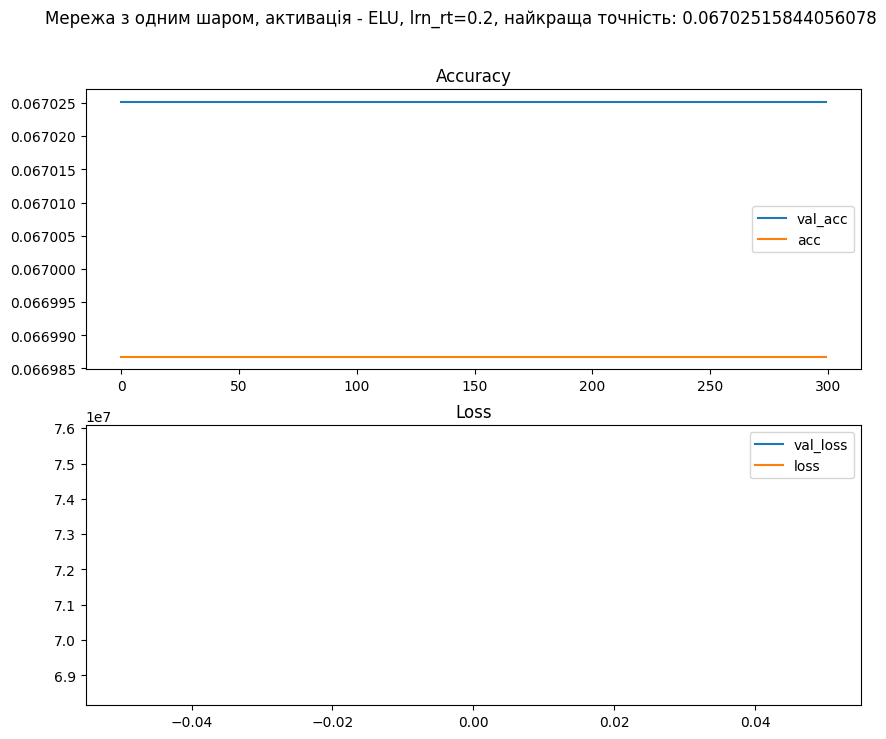

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(f'Мережа з одним шаром, активація - ELU, lrn_rt=0.2, найкраща точність: {max(history["val_acc"])}')

ax[0].plot(history['val_acc'], label='val_acc')
ax[0].plot(history['train_acc'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history['val_loss'], label='val_loss')
ax[1].plot(history['train_loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')